<a href="https://colab.research.google.com/github/ThiagoKoscak/Truck_Air_System/blob/main/Truck_Air_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto para resolução do problema Truck Air System**

# Descrição

O projeto consiste em analisar os dados referentes ao sistema de ar da frota de caminhões da empresa de transporte, visando reduzir os custos de manutenção do mesmo.
<br> Para mais detalhes consultar o arquivo: [Challenge description](https://github.com/ThiagoKoscak/Truck_Air_System/blob/main/Challenge%20description.pdf)

# Objetivo

Criar uma modelo que seja capaz de responder às seguintes questões:

*   É possível reduzir as despesas com esse tipo de manutenção usando técnicas de IA?
*   Quais são os principais fatores que indicam uma possível falha nesse sistema?

# Apresentação

Por fim, foi criada uma apresentação voltada para os gestores não técnicos do projeto:
[Presentation](https://github.com/ThiagoKoscak/Truck_Air_System/blob/main/Presentation.pdf)

In [8]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder # LabelEncoder
import seaborn as sns # plotar gráficos
import matplotlib.pyplot as plt # plotar gráficos
from imblearn.over_sampling import SMOTE # balanceamento
from sklearn.model_selection import train_test_split # divisão treino/teste
from sklearn.model_selection import StratifiedKFold # kfold estretificado
from xgboost import XGBClassifier # modelos
from sklearn.neighbors import KNeighborsClassifier # modelos
from sklearn.linear_model import LogisticRegression # modelos
from sklearn.preprocessing import StandardScaler, MinMaxScaler # padronização e normalização
from sklearn.feature_selection import f_classif, SelectKBest # feature selection
from imblearn.pipeline import Pipeline as imblearnPipeline, Pipeline # pipelines
from sklearn.model_selection import cross_validate # validação cruzada
from sklearn.impute import SimpleImputer # correção de valores nulos para o melhor funcionamento do SelectKBest
!pip install optuna -q # tunning de hiperparametros
import optuna # tunning de hiperparametros
from sklearn.metrics import recall_score, accuracy_score # métricas de recall e acurácia
from sklearn.metrics import confusion_matrix # matriz de confusão


# Para poder ver todas as colunas
pd.set_option('display.max_columns', None)

# 1 - Coleta e análise de dados

In [9]:
# Separação em treino e teste
treino = pd.read_csv("https://raw.githubusercontent.com/ThiagoKoscak/Truck_Air_System/refs/heads/main/air_system_previous_years.csv")
teste = pd.read_csv("https://raw.githubusercontent.com/ThiagoKoscak/Truck_Air_System/refs/heads/main/air_system_present_year.csv")

Não irei me aprofundar na análise de dados, porque não tenho nenhuma informação sobre o conteúdo das colunas e todas elas são numéricas, então vou apenas fazer alguns tratamentos e já seguir para a criação do modelo.

# 2 - Pré-processamento



In [10]:
treino.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

## 2.1 - Ajustando a coluna target

In [ ]:
# LabelEncoder para ajustar a coluna target
le = LabelEncoder()
# No conjunto de treino
treino['class'] = le.fit_transform(treino['class'])
cols = [col for col in treino.columns if col != 'class'] + ['class']
treino = treino[cols]
# No conjunto de teste
teste['class'] = le.fit_transform(teste['class'])
cols = [col for col in teste.columns if col != 'class'] + ['class']
teste = teste[cols]

Nesse ponto podemos verificar que as classes target são muito desbalanceadas.



In [ ]:
treino['class'].value_counts()

,count
class,
0,59000
1,1000


## 2.2 - Tratamento de nulos

Conforme descrito no problema, os nulos estão representados pela string "na". Irei aplicar uma correção para serem tratados como nulos.

In [ ]:
# Tratamento de nulos
# No conjunto de treino
treino.replace({'na': np.nan}, inplace=True)
# No conjunto de teste
teste.replace({'na': np.nan}, inplace=True)

## 2.3 - Verificação e ajuste do tipo das colunas


Como podemos observar, as colunas são na sua maioria do tipo "object" por conta  das antigas strings "na", após o tratamento, será possível convertê-las para valores numéricos.
Me certifiquei de colocar um tratamento de erro (raise), para caso alguma coluna tenha de fato strings, mas não foi o caso.


In [ ]:
treino.dtypes

,0
aa_000,int64
ab_000,object
ac_000,object
ad_000,object
ae_000,object
...,...
ee_008,object
ee_009,object
ef_000,object
eg_000,object


In [ ]:
# Converte todas as colunas do tipo 'object' para numérico

# No conjunto de treino
for column in treino.select_dtypes(include='object').columns:
  # raise para garantir que caso tenha algum valor string, a conversão apresentará um erro
    treino[column] = pd.to_numeric(treino[column], errors='raise')

# No conjunto de teste
for column in teste.select_dtypes(include='object').columns:
  # raise para garantir que caso tenha algum valor string, a conversão apresentará um erro
    teste[column] = pd.to_numeric(teste[column], errors='raise')

In [ ]:
treino.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,59329.000000,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.935500e+04,57275.000000,57273.000000,57497.000000,57500.000000,5.935800e+04,5.935800e+04,5.941100e+04,5.941100e+04,3.696600e+04,3.272300e+04,2.045100e+04,1.599100e+04,1.366700e+04,1.226000e+04,1.127800e+04,1.073600e+04,5.927400e+04,5.983300e+04,5.930900e+04,5.930900e+04,5.674300e+04,5.952700e+04,5.727700e+04,55644.000000,5.927400e+04,5.674500e+04,59324.0,5.749800e+04,4.513900e+04,45139.000000,45139.000000,5.966200e+04,5.966200e+04,5.966200e+04,50447.000000,50123.000000,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,4.513900e+04,57276.000000,5.930900e+04,13671.000000,59331.000000,59331.000000,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,46192.000000,46192.000000,4.619200e+04,4.619200e+04,46192.000000,4.619200e+04,46192.000000,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000,60000.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,1.546032e+06,1.051123e+06,1.162622e+03,7.849608e+03,4.420992e+03,8.066082e+03,8.724082e+

## 2.4 - Separação de targets e features

In [ ]:
# Coluna target
targets = list(treino.columns)
targets = targets[-1]
targets

'class'

In [ ]:
# Lista de features
features=list(treino.columns)
features.remove('class')
features

['aa_000',
 'ab_000',
 'ac_000',
 'ad_000',
 'ae_000',
 'af_000',
 'ag_000',
 'ag_001',
 'ag_002',
 'ag_003',
 'ag_004',
 'ag_005',
 'ag_006',
 'ag_007',
 'ag_008',
 'ag_009',
 'ah_000',
 'ai_000',
 'aj_000',
 'ak_000',
 'al_000',
 'am_0',
 'an_000',
 'ao_000',
 'ap_000',
 'aq_000',
 'ar_000',
 'as_000',
 'at_000',
 'au_000',
 'av_000',
 'ax_000',
 'ay_000',
 'ay_001',
 'ay_002',
 'ay_003',
 'ay_004',
 'ay_005',
 'ay_006',
 'ay_007',
 'ay_008',
 'ay_009',
 'az_000',
 'az_001',
 'az_002',
 'az_003',
 'az_004',
 'az_005',
 'az_006',
 'az_007',
 'az_008',
 'az_009',
 'ba_000',
 'ba_001',
 'ba_002',
 'ba_003',
 'ba_004',
 'ba_005',
 'ba_006',
 'ba_007',
 'ba_008',
 'ba_009',
 'bb_000',
 'bc_000',
 'bd_000',
 'be_000',
 'bf_000',
 'bg_000',
 'bh_000',
 'bi_000',
 'bj_000',
 'bk_000',
 'bl_000',
 'bm_000',
 'bn_000',
 'bo_000',
 'bp_000',
 'bq_000',
 'br_000',
 'bs_000',
 'bt_000',
 'bu_000',
 'bv_000',
 'bx_000',
 'by_000',
 'bz_000',
 'ca_000',
 'cb_000',
 'cc_000',
 'cd_000',
 'ce_000',
 

# 3 - Modelagem

In [ ]:
# Preparando os dados
X = treino[features].copy()
y = treino[targets].copy()

## 3.1  - Feature Selection

Devido aos valores nulos presentes em diversas colunas, estou utilizando o Simple Inputer para popular esses dados.
Fiz teste com "mean", "median" e "most_frequent" e não apresentaram muita diferença nos scores, então resolvir adotar a mediana por ser mais robusta.

In [ ]:
# SelectKBest

# Utilização do SimpleImputer
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Seleção de atributos com SelectKBest, coloquei all para apenas focar na análise de scores
best_var = SelectKBest(score_func=f_classif, k='all')
fit = best_var.fit(X_imputed, y)

# Obtém os nomes das colunas originais
feature_names = X.columns

# Exibe os scores de cada atributo
np.set_printoptions(precision=1)  # 1 casa decimal
scores = fit.scores_
sorted_indices = np.argsort(scores)[::-1]  # Ordena os indices dos scores em ordem decrescente
sorted_scores = scores[sorted_indices]
sorted_features = [feature_names[i] for i in sorted_indices]

print('Número de atributos:', X.shape[1])

print("\nScores dos Atributos Originais (ordenados):")
for score, feature in zip(sorted_scores, sorted_features):
    print(f"{feature:<15} {score:.0f}")


Número de atributos: 170

Scores dos Atributos Originais (ordenados):
cd_000          nan
ci_000          26073
aa_000          24310
bt_000          23970
bb_000          23528
bv_000          23354
bu_000          23354
cq_000          23354
aq_000          22190
bj_000          21532
ah_000          21428
cc_000          21409
an_000          21334
bg_000          21172
ao_000          20939
bx_000          20597
ap_000          20392
by_000          20015
ee_005          18537
bh_000          18525
dn_000          18151
ba_004          17749
cn_004          17370
ck_000          16479
ba_003          16052
ba_005          15362
ag_005          15083
ee_002          14739
cs_005          14570
ba_001          14222
cs_004          14204
ag_003          13849
az_005          13771
ba_000          13666
ee_003          13534
ba_002          13156
bi_000          12858
ee_004          12570
ee_006          12505
ee_000          12504
ay_008          12110
cn_003          11844
ba_006  

## 3.2 - Decisão das quantidades de variáveis

Nessa etapa, estou separando a quantidade de variáveis que possuem maior relevância utilizando um boxplot.

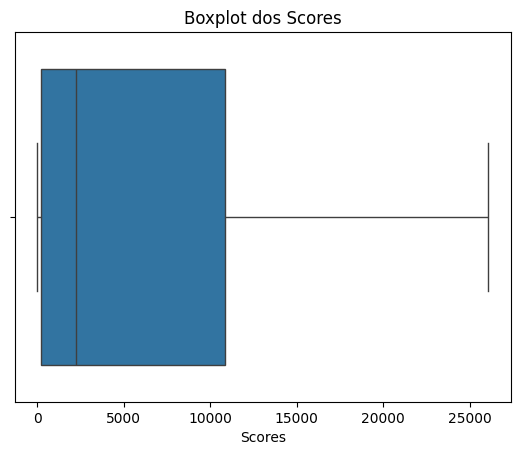

In [ ]:
# Convertendo para numpy array para facilitar a manipulação
scores = np.array(sorted_scores)
feature_names = np.array(sorted_features)

# Filtrar valores NaN
valid_indices = ~np.isnan(scores)
scores = scores[valid_indices]
feature_names = feature_names[valid_indices]

Q3 = np.percentile(scores, 75)  # Terceiro quartil

# Criando o boxplot
sns.boxplot(x=scores)
plt.title('Boxplot dos Scores')
plt.xlabel('Scores')
plt.show()

In [ ]:
principais_fatores = [(feature_names[i], scores[i]) for i in range(len(scores)) if scores[i] >= Q3]
len(principais_fatores)

43

## 3.3 - Verificação de melhores modelos

Obs: Uma vez executado o loop de verificação de melhor modelo e características, eu comentei o código para ganhar tempo nos meus testes, porém mostrei a saída no formato de texto logo em seguida.

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
np.random.seed(7)  # definindo uma semente global
seed = 7 # semente aleatória

# Separação em treino e teste, estratificado uma vez que as classes são desbalanceadas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y)

# Parâmetros e partições da validação cruzada
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

In [ ]:
# Configurações para iteração de modelos
models = [
    ('XGB', XGBClassifier(random_state=seed)),
    ('KNN', KNeighborsClassifier()),
    ('LR', LogisticRegression(random_state=seed))
]

results=[]

# Configurações para iteração de padronização / normalização
scalers = [None, StandardScaler(), MinMaxScaler()]

# Configurações para iteração de balanceamento
samplers = [None, SMOTE(random_state=seed)]

# Configurações para iteração do SelectKBest
k_values = [20, 43, 'all']

# Loop para cada combinação de modelo, scaler, sampler e k_values
for model_name, model in models:
    if model_name == 'LR':
        model.set_params(class_weight='balanced')
    for scaler in scalers:
        for sampler in samplers:
            for k in k_values:
                # Criação dos steps da Pipeline
                steps = []
                # Adicionando o imputador
                steps.append(('imputer', SimpleImputer(strategy='median')))
                # Adicionando o scaler
                if scaler is not None:
                    steps.append(('scaler', scaler))
                # Adicionando o sampler
                if sampler is not None:
                    steps.append(('sampler', sampler))
                # Adicionando SelectKBest
                steps.append(('selectkbest', SelectKBest(score_func=f_classif, k=k)))
                # Adicionando o modelo
                steps.append(('classifier', model))

                pipeline = imblearnPipeline(steps=steps)

                # Realizando a validação cruzada
                cv_results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=['accuracy', 'recall'])

                # Calculando médias
                accuracy_mean = np.mean(cv_results['test_accuracy'])
                recall_mean = np.mean(cv_results['test_recall'])

                # Armazenando os resultados
                results.append({
                    'model': model_name,
                    'scaler': 'None' if scaler is None else scaler.__class__.__name__,
                    'sampler': 'None' if sampler is None else 'SMOTE',
                    'k': k,
                    'recall': recall_mean,
                    'accuracy': accuracy_mean
                })

# Imprimindo cada resultado individualmente
for result in results:
    print(f"Model: {result['model']}, Scaler: {result['scaler']}, Sampler: {result['sampler']}, KBest: {result['k']}, Recall: {result['recall']:.4f}, Accuracy: {result['accuracy']:.4f}")




```
Model: XGB, Scaler: None, Sampler: None, KBest: 20, Recall: 0.5938, Accuracy: 0.9901
Model: XGB, Scaler: None, Sampler: None, KBest: 43, Recall: 0.6950, Accuracy: 0.9930
Model: XGB, Scaler: None, Sampler: None, KBest: all, Recall: 0.7488, Accuracy: 0.9946
Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 20, Recall: 0.8637, Accuracy: 0.9749
Model: XGB, Scaler: None, Sampler: SMOTE, KBest: 43, Recall: 0.8438, Accuracy: 0.9851
Model: XGB, Scaler: None, Sampler: SMOTE, KBest: all, Recall: 0.8162, Accuracy: 0.9925
Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 20, Recall: 0.5938, Accuracy: 0.9901
Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: 43, Recall: 0.6950, Accuracy: 0.9930
Model: XGB, Scaler: StandardScaler, Sampler: None, KBest: all, Recall: 0.7500, Accuracy: 0.9944
Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, Recall: 0.8700, Accuracy: 0.9708
Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: 43, Recall: 0.8488, Accuracy: 0.9838
Model: XGB, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Recall: 0.8075, Accuracy: 0.9924
Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 20, Recall: 0.5938, Accuracy: 0.9901
Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: 43, Recall: 0.6950, Accuracy: 0.9930
Model: XGB, Scaler: MinMaxScaler, Sampler: None, KBest: all, Recall: 0.7488, Accuracy: 0.9946
Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, Recall: 0.8775, Accuracy: 0.9723
Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 43, Recall: 0.8588, Accuracy: 0.9855
Model: XGB, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Recall: 0.8125, Accuracy: 0.9928
Model: KNN, Scaler: None, Sampler: None, KBest: 20, Recall: 0.4050, Accuracy: 0.9861
Model: KNN, Scaler: None, Sampler: None, KBest: 43, Recall: 0.4550, Accuracy: 0.9875
Model: KNN, Scaler: None, Sampler: None, KBest: all, Recall: 0.4088, Accuracy: 0.9868
Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 20, Recall: 0.9075, Accuracy: 0.9569
Model: KNN, Scaler: None, Sampler: SMOTE, KBest: 43, Recall: 0.8975, Accuracy: 0.9637
Model: KNN, Scaler: None, Sampler: SMOTE, KBest: all, Recall: 0.8375, Accuracy: 0.9707
Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 20, Recall: 0.4950, Accuracy: 0.9880
Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: 43, Recall: 0.5750, Accuracy: 0.9906
Model: KNN, Scaler: StandardScaler, Sampler: None, KBest: all, Recall: 0.5125, Accuracy: 0.9898
Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, Recall: 0.9025, Accuracy: 0.9592
Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: 43, Recall: 0.8963, Accuracy: 0.9686
Model: KNN, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Recall: 0.8612, Accuracy: 0.9774
Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 20, Recall: 0.4825, Accuracy: 0.9876
Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: 43, Recall: 0.5375, Accuracy: 0.9892
Model: KNN, Scaler: MinMaxScaler, Sampler: None, KBest: all, Recall: 0.4213, Accuracy: 0.9881
Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, Recall: 0.8975, Accuracy: 0.9612
Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 43, Recall: 0.9037, Accuracy: 0.9688
Model: KNN, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Recall: 0.8650, Accuracy: 0.9741
Model: LR, Scaler: None, Sampler: None, KBest: 20, Recall: 0.9888, Accuracy: 0.2973
Model: LR, Scaler: None, Sampler: None, KBest: 43, Recall: 0.9475, Accuracy: 0.6799
Model: LR, Scaler: None, Sampler: None, KBest: all, Recall: 0.9088, Accuracy: 0.9653
Model: LR, Scaler: None, Sampler: SMOTE, KBest: 20, Recall: 0.9650, Accuracy: 0.5074
Model: LR, Scaler: None, Sampler: SMOTE, KBest: 43, Recall: 0.9100, Accuracy: 0.6805
Model: LR, Scaler: None, Sampler: SMOTE, KBest: all, Recall: 0.9062, Accuracy: 0.9651
Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 20, Recall: 0.9000, Accuracy: 0.9662
Model: LR, Scaler: StandardScaler, Sampler: None, KBest: 43, Recall: 0.9137, Accuracy: 0.9710
Model: LR, Scaler: StandardScaler, Sampler: None, KBest: all, Recall: 0.8925, Accuracy: 0.9742
Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 20, Recall: 0.8962, Accuracy: 0.9670
Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 43, Recall: 0.9050, Accuracy: 0.9684
Model: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: all, Recall: 0.8838, Accuracy: 0.9742
Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 20, Recall: 0.9000, Accuracy: 0.9631
Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 43, Recall: 0.9062, Accuracy: 0.9674
Model: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, Recall: 0.9225, Accuracy: 0.9699
Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 20, Recall: 0.9025, Accuracy: 0.9636
Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 43, Recall: 0.9137, Accuracy: 0.9661
Model: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Recall: 0.9187, Accuracy: 0.9725
```



## 3.4 - Escolha do modelo

Nessa etapa, a métrica mais importante para a escolha do modelo é o Recall, uma vez que falsos negativos têm um custo muito elevado para a empresa (USD 500 contra USD 10 e USD 25 para falsos positivos e verdadeiros positivos, respectivamente). Isso significa que é crucial minimizar a ocorrência de falsos negativos, pois esses casos resultam em reparos caros. Além do recall, também estou considerando a Acurácia, que, embora possa não ser tão eficaz em cenários com classes extremamente desbalanceadas, ainda oferece uma garantia de que estamos acertando a maioria dos casos. Para chegar a essa conclusão, utilizei uma ponderação entre as métricas e realizei alguns testes manuais para determinar o melhor modelo a ser utilizado neste caso.

Obs: Comentei essa parte do código já que não teríamos a variável "results" populada, devido o código do item anterior também estar comentado, porém mostrei a saída no formato de texto logo em seguida.

In [ ]:
# Define os pesos para a média ponderada
weight_recall = 0.7
weight_accuracy = 0.3

In [ ]:
# # Calcula a média ponderada e adiciona ao dicionário de métricas
# for result in results:
#     avg_recall = result['recall']
#     avg_accuracy = result['accuracy']
#     weighted_avg = (weight_recall * avg_recall) + (weight_accuracy * avg_accuracy)
#     result['avg_recall'] = avg_recall
#     result['avg_accuracy'] = avg_accuracy
#     result['weighted_avg'] = weighted_avg

# # Ordena as combinações gerais pela média ponderada em ordem decrescente
# sorted_global_combinations = sorted(results, key=lambda x: x['weighted_avg'], reverse=True)

# # Imprime as top 10 combinações gerais com base na média ponderada
# print("\nTop 10 Combinações Gerais Baseadas na Média Ponderada de Recall e Acurácia:")
# for i, result in enumerate(sorted_global_combinations[:10], start=1):
#     print(f"{i}. Modelo: {result['model']}, Scaler: {result['scaler']}, "
#           f"Sampler: {result['sampler']}, KBest: {result['k']}, "
#           f"Média Ponderada: {result['weighted_avg']:.4f}, Média Recall: {result['avg_recall']:.4f}, "
#           f"Média de Acurácia: {result['avg_accuracy']:.4f}")




```
Top 10 Combinações Gerais Baseadas na Média Ponderada de Recall e Acurácia:
1. Modelo: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, Média Ponderada: 0.9367, Média Recall: 0.9225, Média de Acurácia: 0.9699
2. Modelo: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Média Ponderada: 0.9349, Média Recall: 0.9187, Média de Acurácia: 0.9725
3. Modelo: LR, Scaler: StandardScaler, Sampler: None, KBest: 43, Média Ponderada: 0.9309, Média Recall: 0.9137, Média de Acurácia: 0.9710
4. Modelo: LR, Scaler: MinMaxScaler, Sampler: None, KBest: all, Média Ponderada: 0.9305, Média Recall: 0.9146, Média de Acurácia: 0.9677
5. Modelo: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: 43, Média Ponderada: 0.9295, Média Recall: 0.9137, Média de Acurácia: 0.9661
6. Modelo: LR, Scaler: None, Sampler: None, KBest: all, Média Ponderada: 0.9294, Média Recall: 0.9145, Média de Acurácia: 0.9640
7. Modelo: LR, Scaler: MinMaxScaler, Sampler: SMOTE, KBest: all, Média Ponderada: 0.9283, Média Recall: 0.9102, Média de Acurácia: 0.9705
8. Modelo: LR, Scaler: None, Sampler: None, KBest: all, Média Ponderada: 0.9257, Média Recall: 0.9088, Média de Acurácia: 0.9653
9. Modelo: LR, Scaler: MinMaxScaler, Sampler: None, KBest: 43, Média Ponderada: 0.9246, Média Recall: 0.9062, Média de Acurácia: 0.9674
10. Modelo: LR, Scaler: StandardScaler, Sampler: SMOTE, KBest: 43, Média Ponderada: 0.9240, Média Recall: 0.9050, Média de Acurácia: 0.9684
```



## 3.5 - Tunning de hiperparâmetros

Uma vez escolhido o modelo de Regressão Logística, por ter apresentado a melhor média na etapa passada, vamos fazer um tunning de hiperparâmetros utilizando a biblioteca Optuna.
Como o modelo já estava performando muito bem com uma média moderada de 0,9367, a utilização desse tunning trouxe uma leve melhoria para uma média de 0,9539.
<br>Obs: Após uma execução de 2 horas e 30 minutos aproximandamente, comentei o trecho de código e setei as variáveis manualmente para facilitar meus testes.
Mostrei a saída no formato de texto logo em seguida.

In [ ]:
# Definindo a função objetivo para Optuna
def objective(trial):
    # Definindo hiperparâmetros a serem testados
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
    solver = 'lbfgs'  # Padrão, será modificado conforme o penalty

    if penalty == 'none':
        solver = 'lbfgs'
    elif penalty in ['l1', 'elasticnet']:
        solver = 'saga'
    else:
        solver = trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cg', 'liblinear'])

    param = {
        'C': trial.suggest_loguniform('C', 1e-6, 1e+6),
        'penalty': penalty,
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    if penalty == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
    param['solver'] = solver

    # Adicionando class_weight
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    param['class_weight'] = class_weight

    # Aplicando o SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    imputer = SimpleImputer(strategy='median')
    X_test_imputed = imputer.fit_transform(X_test)

    # Aplicando o MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Treinando o modelo com os hiperparâmetros definidos
    model = LogisticRegression(**param)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

    # Calculando recall e acurácia
    recall = recall_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)

    # Calculando a média ponderada
    weighted_avg = (weight_recall * recall) + (weight_accuracy * accuracy)
    return weighted_avg

# Configurando o estudo do Optuna para maximizar a média ponderada
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Obtendo os melhores hiperparâmetros encontrados
best_params = study.best_trial.params

# Ajustando solver para 'saga' se o penalty for 'l1' ou 'elasticnet'
if best_params['penalty'] in ['l1', 'elasticnet']:
    best_params['solver'] = 'saga'
elif best_params['penalty'] == 'none':
    best_params['solver'] = 'lbfgs'

# Imprimindo os resultados
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', best_params)
print('Best Weighted Average score:', study.best_trial.value)




```
Number of finished trials: 100
Best trial parameters: {'penalty': 'elasticnet', 'C': 14.809971468618404, 'max_iter': 692, 'l1_ratio': 0.018966267009969506, 'class_weight': 'balanced', 'solver': 'saga'}
Best Weighted Average score: 0.953875
```



In [ ]:
# Baseado nos melhores parâmetros da execução do optuna
best_params = {
    'penalty': 'elasticnet',
    'C': 14.809971468618404,
    'max_iter': 692,
    'l1_ratio': 0.018966267009969506,
    'class_weight': 'balanced',
    'solver': 'saga'
}

## 3.6 - Última verificação antes do treinamento do modelo

Aqui irei fazer a execução do modelo LR com as características que trouxeram melhor resultado em conjunto com os hiperparâmetros descobertos:

<br>Modelo: LR
<br>Scaler: MinMaxScaler
<br>Sampler: None
<br>SelectKBest: all
<br>Média Ponderada: 0.9367
<br>Média Recall: 0.9225
<br>Média de Acurácia: 0.9699
<br>
<br>Hiperparâmetros: {'penalty': 'elasticnet', 'C': 14.809971468618404, 'max_iter': 692, 'l1_ratio': 0.018966267009969506, 'class_weight': 'balanced', 'solver': 'saga'}
<br>Nova Média Ponderada: 0.953875

In [ ]:
#Preparação da execução
steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(**best_params, random_state=seed))
]

# Criando a pipeline
pipeline = Pipeline(steps=steps)

#Treinando o modelo
pipeline.fit(X_train, y_train)

#Testando o modelo
predictions = pipeline.predict(X_test)

# Calculando as métricas
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
weighted_avg = (weight_recall * recall) + (weight_accuracy * accuracy)

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions)

# Imprimindo as métricas e a matriz de confusão
print(f"Recall: {recall:.4f}, Acurácia: {accuracy:.4f}")
print(f"Média Ponderada: {weighted_avg:.4f}")
print("Matriz de Confusão:\n", conf_matrix)

Recall: 0.9450, Acurácia: 0.9745
Média Ponderada: 0.9538
Matriz de Confusão:
 [[11505   295]
 [   11   189]]


## 3.7 - Treinando o modelo

Treinamento do modelo com todo o conjunto de dados de treino



In [ ]:
#Preparação da execução
steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(**best_params, random_state=seed))
]

# Criando a pipeline
pipeline = Pipeline(steps=steps)

#Treinando o modelo
pipeline.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=14.809971468618404,
                                    class_weight='balanced',
                                    l1_ratio=0.018966267009969506, max_iter=692,
                                    penalty='elasticnet', random_state=7,
                                    solver='saga'))])

## 3.8 - Execução nos dados de 2022

Após o treinamento do modelo com os dados anteriores a 2022, farei a execução com os dados de 2022 (dados de teste).
<br>Aqui será possível analisar que o modelo se mostrou extremamente eficiente tendo uma quantidade extremamente baixa de falsos negativos, o que irá reduzir muito os custos, conforme iremos ver nas próximas etapas.

Recall: 0.9253, Acurácia: 0.9753
Média Ponderada: 0.9403


Text(0.5, 1.0, 'Matriz de Confusão')

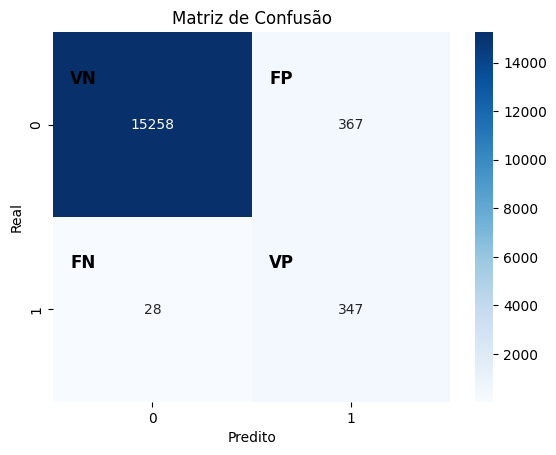

In [ ]:
# Preparando os dados de teste
teste_X = teste[features].copy()
teste_y = teste[targets].copy()

#Testando o modelo
predictions = pipeline.predict(teste_X)

# Calculando as métricas
accuracy = accuracy_score(teste_y, predictions)
recall = recall_score(teste_y, predictions)
weighted_avg = (weight_recall * recall) + (weight_accuracy * accuracy)

# Matriz de confusão
conf_matrix = confusion_matrix(teste_y, predictions)

# Imprimindo as métricas
print(f"Recall: {recall:.4f}, Acurácia: {accuracy:.4f}")
print(f"Média Ponderada: {weighted_avg:.4f}")

# matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# Adicionar VP, VN, FP, FN
plt.text(0.15, 0.25, 'VN', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(1.15, 0.25, 'FP', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(0.15, 1.25, 'FN', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(1.15, 1.25, 'VP', ha='center', va='center', fontsize=12, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

# 4 - Pós-processamento

## 4.1 - Coleta de variáveis mais importantes

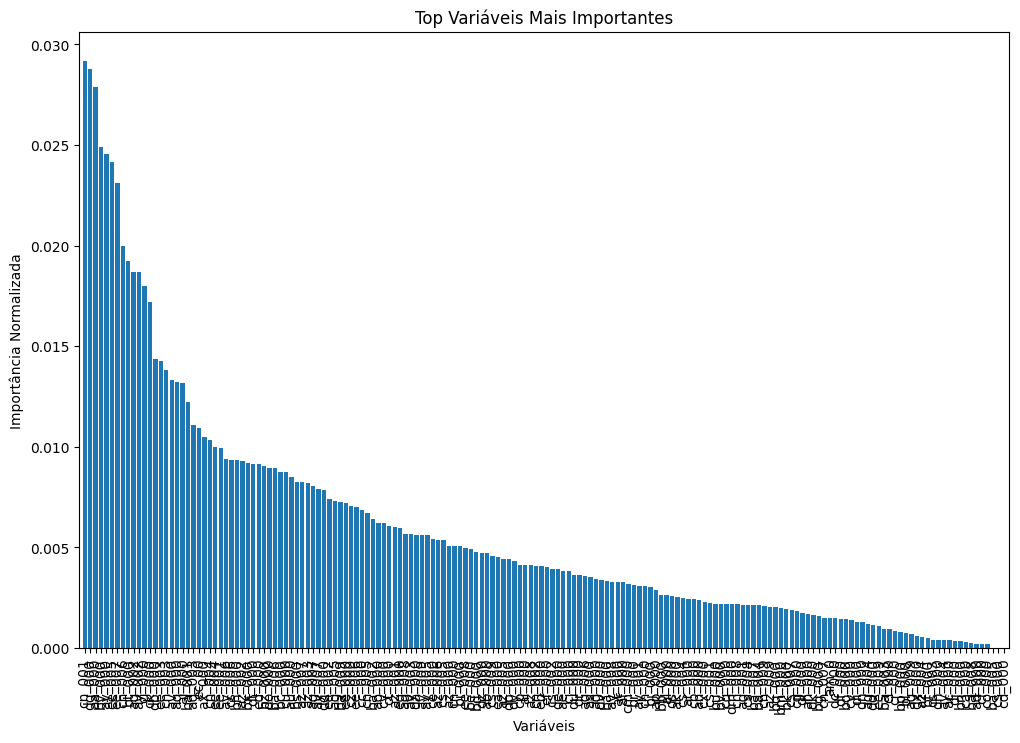

In [ ]:
# Acessando o modelo treinado
model = pipeline.named_steps['model']

# Obtendo os coeficientes do modelo
coefficients = model.coef_[0]

# Calculando as importâncias
importances = np.abs(coefficients)
importances = importances / np.sum(importances)

# Obtendo os nomes das variáveis
feature_names = X_train.columns

# Ordenando as importâncias e os nomes das variáveis
indices = np.argsort(importances)[::-1]
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]

# Criando o gráfico
plt.figure(figsize=(12, 8))
plt.title("Top Variáveis Mais Importantes")
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_feature_names, rotation=90)
plt.xlim([-1, len(sorted_importances)])
plt.xlabel('Variáveis')
plt.ylabel('Importância Normalizada')
plt.show()


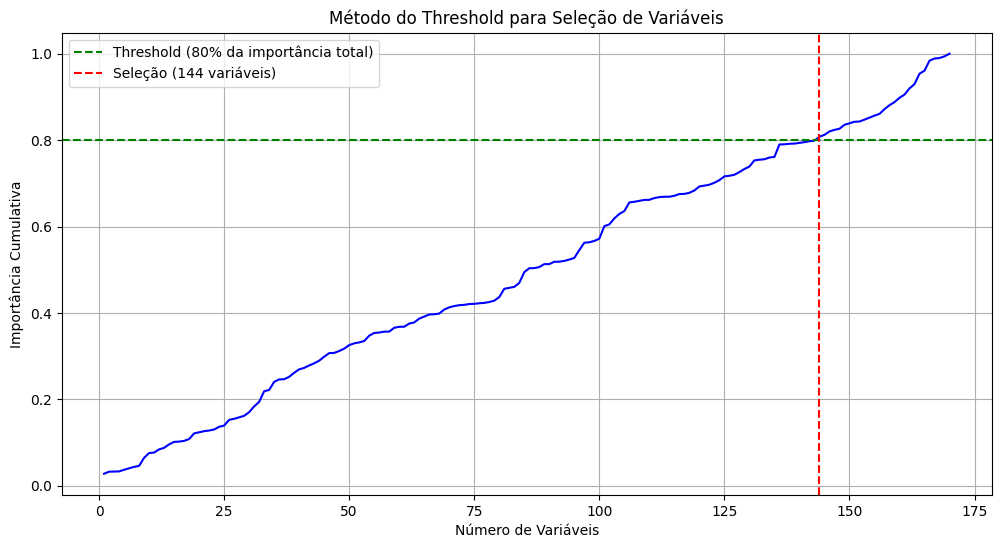

Número recomendado de variáveis: 144
Variáveis selecionadas:
Index(['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000',
       'ag_001', 'ag_002', 'ag_003',
       ...
       'df_000', 'dg_000', 'dh_000', 'di_000', 'dj_000', 'dk_000', 'dl_000',
       'dm_000', 'dn_000', 'do_000'],
      dtype='object', length=144)


In [ ]:
# Calcular as importâncias cumulativas
cum_importances = np.cumsum(importances)
total_importance = cum_importances[-1]

# Definir o threshold
threshold = 0.8 * total_importance

# Encontrar o índice onde a importância cumulativa ultrapassa o threshold
elbow_index = np.where(cum_importances >= threshold)[0][0]

# Número de variáveis a serem selecionadas
n_selected = elbow_index + 1

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(importances) + 1), cum_importances, 'b-')
plt.axhline(y=threshold, color='g', linestyle='--', label=f'Threshold (80% da importância total)')
plt.axvline(x=n_selected, color='r', linestyle='--', label=f'Seleção ({n_selected} variáveis)')
plt.xlabel('Número de Variáveis')
plt.ylabel('Importância Cumulativa')
plt.title('Método do Threshold para Seleção de Variáveis')
plt.legend()
plt.grid(True)
plt.show()

print(f"Número recomendado de variáveis: {n_selected}")
print("Variáveis selecionadas:")
print(feature_names[:n_selected])

In [ ]:
top_feature_names = feature_names[:n_selected]

## 4.2 - Treinando o modelo otimizado

Nessa etapa após coletar as variáveis mais importantes para o modelo, testei diversos threshoulds até chegar no que performou melhor.
<br> Dessa forma estou trazendo 144 variáveis fazendo com que haja um pequeno ganho de recall sem que praticamente haja perda em acurácia.

In [ ]:
# Filtrando o conjunto de dados para incluir apenas as variáveis selecionadas
X_train_reduced = X[top_feature_names]

#Preparação da execução
steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(**best_params, random_state=seed))
]

# Criando a pipeline
pipeline = Pipeline(steps=steps)

#Treinando o modelo
pipeline.fit(X_train_reduced, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=14.809971468618404,
                                    class_weight='balanced',
                                    l1_ratio=0.018966267009969506, max_iter=692,
                                    penalty='elasticnet', random_state=7,
                                    solver='saga'))])

Recall: 0.9387, Acurácia: 0.9742
Média Ponderada: 0.9493


Text(0.5, 1.0, 'Matriz de Confusão')

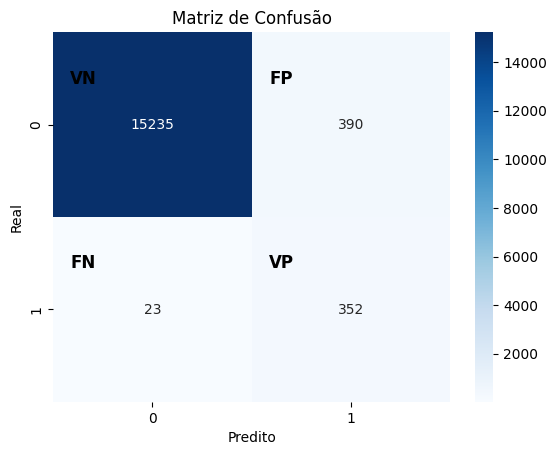

In [ ]:
# Preparando os dados de teste
teste_X = teste[top_feature_names].copy()
teste_y = teste[targets].copy()

#Testando o modelo
predictions = pipeline.predict(teste_X)

# Calculando as métricas
accuracy = accuracy_score(teste_y, predictions)
recall = recall_score(teste_y, predictions)
weighted_avg = (weight_recall * recall) + (weight_accuracy * accuracy)

# Matriz de confusão
conf_matrix = confusion_matrix(teste_y, predictions)

# Imprimindo as métricas
print(f"Recall: {recall:.4f}, Acurácia: {accuracy:.4f}")
print(f"Média Ponderada: {weighted_avg:.4f}")

# matriz de confusão
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# Adicionar VP, VN, FP, FN
plt.text(0.15, 0.25, 'VN', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(1.15, 0.25, 'FP', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(0.15, 1.25, 'FN', ha='center', va='center', fontsize=12, fontweight='bold')
plt.text(1.15, 1.25, 'VP', ha='center', va='center', fontsize=12, fontweight='bold')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

# 5 - Apresentação dos resultados

## 5.1 - Explicação

O ponto mais imporante desse problema é saber qual o custo de manutenção que o modelo irá trazer e qual a redução em relação aos custos que a empresa teve nos ano de 2022.
<br> Para chegar nesses valores, vou adotar a seguinte fómula:
<br> Custo Total=(FNx500)+(FPx10)+(VPx25)
<br> Uma vez tendo esses custos, irei gerar o custo projetado de 2022 para poder fazer um comparativo.

## 5.2 - Calculando o custo de cada modelo

#### 5.2.1 - Modelo 1

O modelo 1 teve as seguintes saídas:
<br>Recall: 0.9253 (Peso 0.7)
<br>Acurácia: 0.9753 (Peso 0.3)
<br>Média Ponderada: 0.9403
<br>
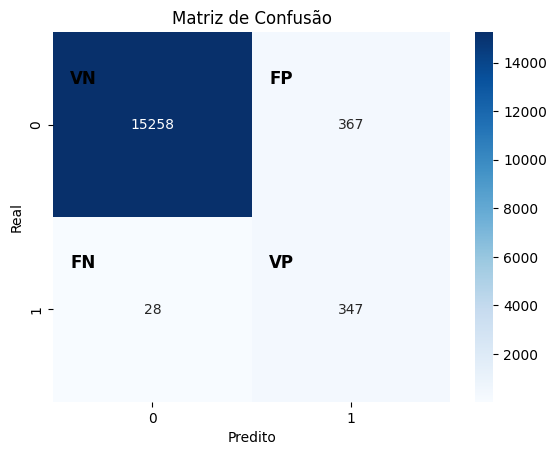

In [ ]:
custo_modelo1 = (28 * 500) + (367 * 10) + (347 * 25)
print(f"Custo previsto pelo modelo 1: USD {custo_modelo1:.0f}")

Custo previsto pelo modelo 1: USD 26345


#### 5.2.2 - Modelo 2

O modelo 2 teve as seguintes saídas:
<br>Recall: 0.9387 (Peso 0.7)
<br>Acurácia: 0.9742 (Peso 0.3)
<br>Média Ponderada: 0.9493
<br><br>
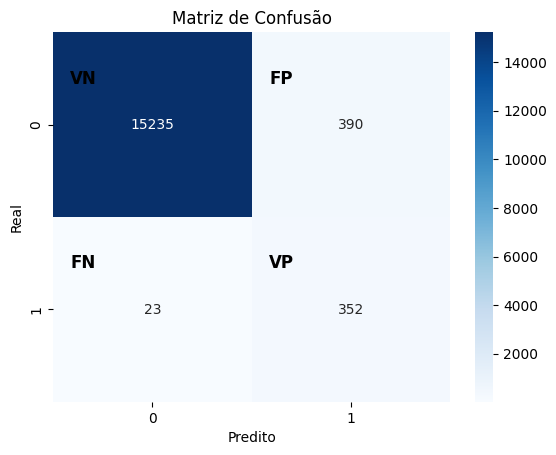

In [ ]:
custo_modelo2 = (23 * 500) + (390 * 10) + (352 * 25)
print(f"Custo previsto pelo modelo 2: USD {custo_modelo2:.0f}")

Custo previsto pelo modelo 2: USD 24200


### 5.2.3 Comparando os modelos
Comparando os dois modelos, podemos ver que o modelo 2 é 8,1% mais econômico do que o modelo 1, gerando uma redução de USD 2145.

In [ ]:
# cálculo de diferença dos modelos
dif = custo_modelo1 - custo_modelo2
# cálculo de porcentagem
percent = 100 -(custo_modelo2 / custo_modelo1 * 100)

print(f"Diferença entre os modelos: USD {dif:.0f}")
print(f"Porcentagem de econômica com o modelo 2: {percent:.2f} %")

Diferença entre os modelos: USD 2145
Porcentagem de econômica com o modelo 2: 8.14 %


## 5.3 - Projetando o valor de 2022

Nessa etapa irei projetar qual o custo de manutenção do sistema de ar dos caminhões de acorda com esse crescimento:
<br>
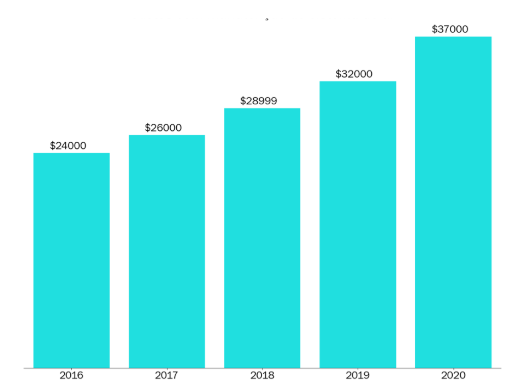

### 5.3.1 Cálculos

Fómula do CAGR (Cálculo do Crescimento Médio):
<br>
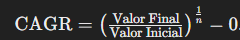
<br><br>
Fórmula de valor futuro:
<br>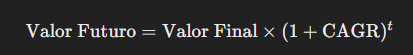

In [ ]:
# Valor inicial, final e número de anos
valor_inicial = 24000
valor_final = 37000
qtd_anos = 5

# Cálculo do CAGR
cagr = ((valor_final / valor_inicial) ** (1 / qtd_anos)) - 1
cagr_percent = cagr * 100

# Valor Futuro=Valor Final×(1+CAGR)**t
qtd_anos_futuro = 2
valor_2022 = valor_final * (1 + cagr) ** qtd_anos_futuro

# Imprimir os resultados
print(f"CAGR: {cagr_percent:.2f} %")
print(f"Valor projetado para 2022: USD {valor_2022:.0f}")

CAGR: 9.04 %
Valor projetado para 2022: USD 43994


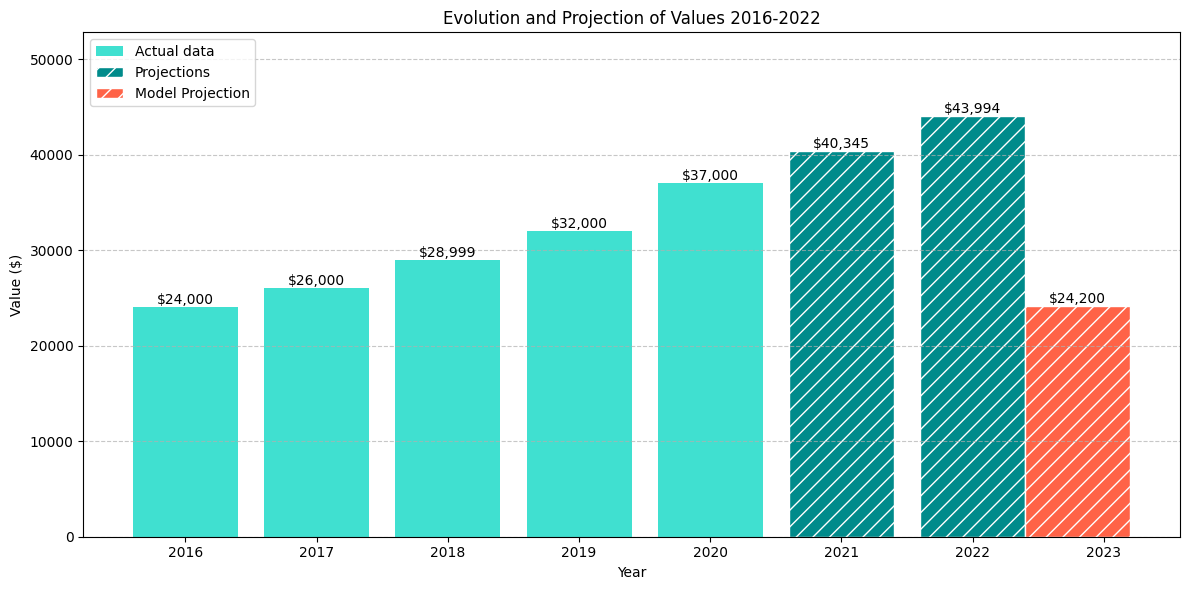

In [ ]:
import matplotlib.pyplot as plt

# Data
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2022.1]
values = [24000, 26000, 28999, 32000, 37000, 40345, 43994, 24200]
colors = ['#40E0D0'] * 5 + ['#008B8B'] * 2 + ['#FF6347']  # Turquoise for real data, dark blue for projections, tomato for model projection

# Create the graph
fig, ax = plt.subplots(figsize=(12, 6))

# Bars for real data
real_bars = ax.bar(years[:5], values[:5], color='#40E0D0', label='Actual data')

# Bars for projections
projection_bars = ax.bar(years[5:7], values[5:7], color='#008B8B', hatch='//', edgecolor='white', label='Projections')

# Bar for model projection, adjusted to be right next to projections
model_projection_bar = ax.bar(years[6] + 0.8, values[7], color='#FF6347', hatch='//', edgecolor='white', label='Model Projection')

# Customization
ax.set_ylabel('Value ($)')
ax.set_xlabel('Year')
ax.set_title('Evolution and Projection of Values 2016-2022')

# Add values on top of the bars
for i, v in enumerate(values):
    if i < 7:
        ax.text(years[i], v, f'${v:,}', ha='center', va='bottom')
    else:
        ax.text(years[6] + 0.8, v, f'${v:,}', ha='center', va='bottom')

# Adjust Y-axis limits
ax.set_ylim(0, max(values) * 1.2)

# Legend
ax.legend(loc='upper left')

# Grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## 5.4 - Respondendo as perguntas do problema

### 5.4.1 - É possível reduzir as despesas com esse tipo de manutenção usando técnicas de IA?

**R:** Sim, é possível!
<br>Conforme vericamos nos itens anteriores fomos capazes de alcançar valores muito mais baixos do que os projetados para 2022.
<br>Observe os dados referentes aos custos:

In [ ]:
economia = valor_2022 - custo_modelo2
economia_percent = ((economia / valor_2022 ) * 100)
print(f"Valor projetado para 2022: USD {valor_2022:.0f}")
print(f"Custo previsto pelo modelo 2 para 2022: USD {custo_modelo2:.0f}")
print(f"Caso o modelo 2 fosse utilizado em 2022 geraria uma economia de: USD {economia:.0f}")
print(f"Porcentagem de econômica com o modelo 2: {economia_percent:.2f} %")

Valor projetado para 2022: USD 43994
Custo previsto pelo modelo 2 para 2022: USD 24200
Caso o modelo 2 fosse utilizado em 2022 geraria uma economia de: USD 19794
Porcentagem de econômica com o modelo 2: 44.99 %


### 5.4.2 - Quais são os principais fatores que indicam uma possível falha nesse sistema?

Para identificar os principais fatores que indicam uma possível falha no sistema, trouxe os coeficientes do modelo utilizado (Regressão Logística). Ao contrário da análise anterior, onde os coeficientes foram normalizados, nesta seção apresento os coeficientes em sua forma original.
<br>Essa abordagem nos permite identificar quais variáveis têm uma relação direta (proporcional) ou inversa (inversamente proporcional) com a probabilidade de falha. Coeficientes positivos indicam uma associação direta, aumentando a probabilidade de falha à medida que o valor da variável aumenta. Enquanto os coeficientes negativos indicam uma associação inversa, onde um aumento na variável está relacionado a uma diminuição na probabilidade de falha.
<br> Trouxe os coeficientes que possuem valores absolutos acima de 20, conforme dados e gráfico a seguir:

Variáveis com Maior Influência Positiva:
cn_001: 31.9458
dg_000: 31.5562
aa_000: 30.5325
by_000: 27.3034
ay_000: 26.9187
ee_005: 26.4474
ag_002: 20.4782
ay_002: 20.4566

Variáveis com Maior Influência Negativa:
ee_007: -25.3476
cn_006: -21.8910
bt_000: -21.0977


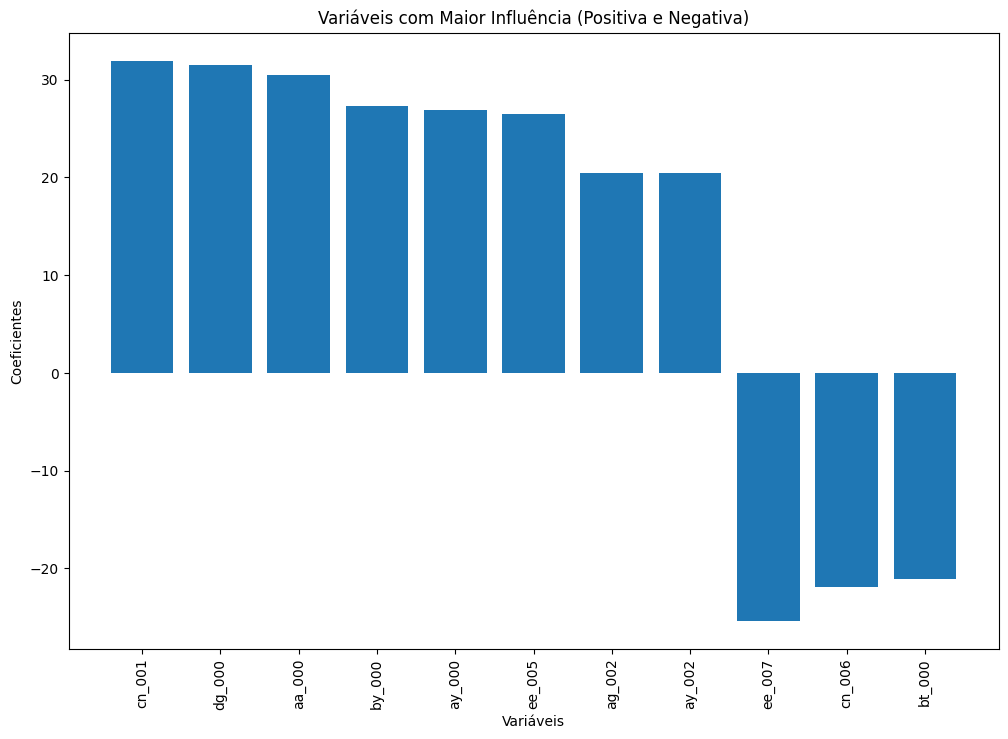

In [ ]:
# Obtendo os coeficientes do modelo
coefficients = model.coef_[0]

# Ordenando os coeficientes e os nomes das variáveis de forma decrescente e crescente
sorted_indices_desc = np.argsort(coefficients)[::-1]  # Indices para ordenação decrescente
sorted_indices_asc = np.argsort(coefficients)  # Indices para ordenação crescente

# Selecionando as top variáveis mais positivas e mais negativas
top_positive_indices = sorted_indices_desc[:8]
top_negative_indices = sorted_indices_asc[:3]

# Coletando os nomes das variáveis e os coeficientes
top_positive_features = X_train.columns[top_positive_indices]
top_positive_coefficients = coefficients[top_positive_indices]

top_negative_features = X_train.columns[top_negative_indices]
top_negative_coefficients = coefficients[top_negative_indices]

# Apresentando os resultados
print("Variáveis com Maior Influência Positiva:")
for feature, coef in zip(top_positive_features, top_positive_coefficients):
    print(f"{feature}: {coef:.4f}")

print("\nVariáveis com Maior Influência Negativa:")
for feature, coef in zip(top_negative_features, top_negative_coefficients):
    print(f"{feature}: {coef:.4f}")

# Opcional: Visualizar as variáveis mais influentes
plt.figure(figsize=(12, 8))
plt.title("Variáveis com Maior Influência (Positiva e Negativa)")

# Concatenando para um gráfico combinado
features_combined = np.concatenate([top_positive_features, top_negative_features])
coefficients_combined = np.concatenate([top_positive_coefficients, top_negative_coefficients])
indices_combined = np.arange(len(features_combined))

plt.bar(indices_combined, coefficients_combined, align="center")
plt.xticks(indices_combined, features_combined, rotation=90)
plt.xlabel('Variáveis')
plt.ylabel('Coeficientes')
plt.show()
